In [33]:
using DataFrames, CSV, XLSX
using Optim
using PyPlot
using Test

ArgumentError: ArgumentError: Package XSLX not found in current path:
- Run `import Pkg; Pkg.add("XSLX")` to install the XSLX package.


In [34]:
using Pkg; Pkg.add("XLSX")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [35]:
import XLSX

In [59]:
xf = XLSX.readxlsx("Charakterisierung_der_Bahn.xlsx")

XLSXFile("Charakterisierung_der_Bahn.xlsx") containing 1 Worksheet
            sheetname size          range        
-------------------------------------------------
               Blatt1 146x2         A1:B146      


In [65]:
fname = "Charakterisierung_der_Bahn.xlsx"

f = XLSX.readxlsx(fname)

XLSXFile("Charakterisierung_der_Bahn.xlsx") containing 1 Worksheet
            sheetname size          range        
-------------------------------------------------
               Blatt1 146x2         A1:B146      


In [67]:
car1 = DataFrame(XLSX.readtable(fname, "Blatt1", "A:B", 
        column_labels = ["time", "pos"],
        infer_eltypes = true
            )...)
first(car1, 4)

,time,pos
,Any,Float64
1,0.0333333,0.00780682
2,0.0666667,0.018943
3,0.1,0.0294527
4,0.133333,0.0406405


In [68]:
car1.time = float.(car1.time)
first(car1, 4)

,time,pos
,Float64,Float64
1,0.0333333,0.00780682
2,0.0666667,0.018943
3,0.1,0.0294527
4,0.133333,0.0406405


In [71]:
# car2 = DataFrame(XLSX.readtable(fname, "Blatt1", "C:D", 
#        column_labels = ["time", "pos"],        infer_eltypes = true
#            )...)
#first(car2, 4) 

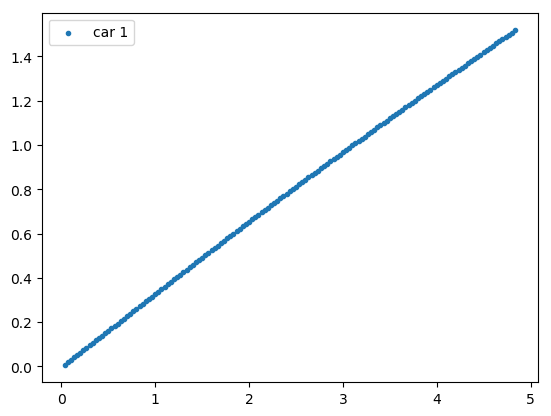

PyObject <matplotlib.legend.Legend object at 0x94d4e830>

In [82]:
scatter(car1.time, car1.pos, label = "car 1", marker =".")
legend()

function two_piece_linear(x, para)
    n   = para[1]
    m1  = para[2]
    m2  = para[3]
    x12 = para[4]
    if x < x12
        n + m1 * x
    else
        n + m1 * x12 + m2 * (x - x12)
    end
end

In [94]:
function two_piece_linear(x, para)
    n   = para[1]
    m1  = para[2]
    m2  = para[3]
    x12 = para[4]
    if x < x12
        n + m1 * x
    else
        n + m1 * x12 + m2 * (x - x12)
    end
end

two_piece_linear (generic function with 1 method)

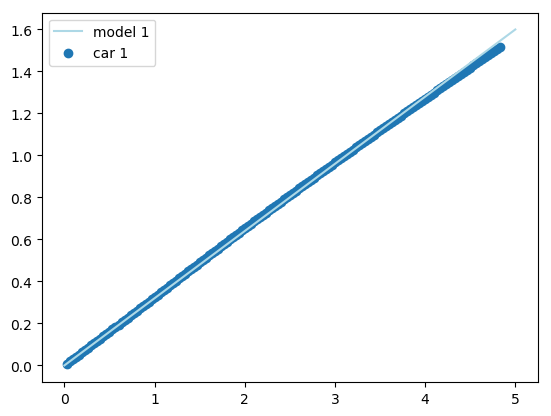

PyObject <matplotlib.legend.Legend object at 0x84e96790>

In [100]:
scatter(car1.time, car1.pos, label = "car 1")


# car 1
times = 0:0.01:5.0
para1 = [0.0, 0.32, 0.32, 1.1]
model_car1 = map(t -> two_piece_linear(t, para1), times)
plot(times, model_car1, color = "lightblue", label = "model 1")

# car 2
#para2 = [0.0, 0.4, 0.1, 1.2]

#model_car2 = map(t -> two_piece_linear(t, para2), times)
#plot(times, model_car2, color = "red", label = "model 2")

legend()

In [119]:
obs_data = DataFrame(XLSX.readtable(fname, "Blatt1", "A:B"))

,x1
,Any
1,"[0.0333333, 0.0666667, 0.1, 0.133333, 0.166667, 0.2, 0.233333, 0.266667, 0.3, 0.333333, 0.366667, 0.4, 0.433333, 0.466667, 0.5, 0.533333, 0.566667, 0.6, 0.633333, 0.666667, 0.7, 0.733333, 0.766667, 0.8, 0.833333, 0.866667, 0.9, 0.933333, 0.966667, 1, 1.03333, 1.06667, 1.1, 1.13333, 1.16667, 1.2, 1.23333, 1.26667, 1.3, 1.33333, 1.36667, 1.4, 1.43333, 1.46667, 1.5, 1.53333, 1.56667, 1.6, 1.63333, 1.66667, 1.7, 1.73333, 1.76667, 1.8, 1.83333, 1.86667, 1.9, 1.93333, 1.96667, 2, 2.03333, 2.06667, 2.1, 2.13333, 2.16667, 2.2, 2.23333, 2.26667, 2.3, 2.33333, 2.36667, 2.4, 2.43333, 2.46667, 2.5, 2.53333, 2.56667, 2.6, 2.63333, 2.66667, 2.7, 2.73333, 2.76667, 2.8, 2.83333, 2.86667, 2.9, 2.93333, 2.96667, 3, 3.03333, 3.06667, 3.1, 3.13333, 3.16667, 3.2, 3.23333, 3.26667, 3.3, 3.33333, 3.36667, 3.4, 3.43333, 3.46667, 3.5, 3.53333, 3.56667, 3.6, 3.63333, 3.66667, 3.7, 3.73333, 3.76667, 3.8, 3.83333, 3.86667, 3.9, 3.93333, 3.96667, 4, 4.03333, 4.06667, 4.1, 4.13333, 4.16667, 4.2, 4.23333, 4.26667, 4.3, 4.33333, 4.36667, 4.4, 4.43333, 4.46667, 4.5, 4.53333, 4.56667, 4.6, 4.63333, 4.66667, 4.7, 4.73333, 4.76667, 4.8, 4.83333]"
2,"[0.00780682, 0.018943, 0.0294527, 0.0406405, 0.0512696, 0.0619471, 0.0733033, 0.0841442, 0.0951995, 0.10573, 0.117057, 0.12794, 0.138734, 0.149958, 0.161263, 0.171528, 0.182386, 0.193263, 0.204826, 0.21583, 0.227266, 0.237744, 0.248966, 0.25986, 0.27107, 0.28208, 0.292876, 0.304063, 0.315166, 0.326215, 0.337039, 0.348285, 0.359387, 0.370533, 0.381714, 0.392365, 0.403099, 0.414298, 0.425568, 0.436058, 0.447441, 0.4586, 0.469555, 0.48023, 0.49119, 0.502181, 0.512995, 0.524152, 0.534929, 0.545552, 0.556347, 0.567337, 0.578475, 0.58954, 0.599871, 0.610797, 0.621513, 0.632286, 0.642821, 0.653898, 0.664488, 0.674641, 0.68581, 0.696039, 0.70661, 0.717165, 0.727712, 0.738486, 0.749038, 0.759337, 0.7698, 0.780023, 0.790518, 0.801277, 0.811742, 0.821824, 0.832572, 0.843023, 0.853298, 0.863544, 0.874059, 0.884414, 0.89497, 0.904874, 0.915441, 0.925484, 0.935726, 0.946263, 0.956706, 0.966888, 0.977025, 0.987624, 0.998441, 1.00802, 1.01779, 1.02811, 1.03809, 1.04869, 1.05907, 1.06894, 1.07899, 1.08953, 1.09952, 1.10962, 1.11998, 1.12945, 1.13992, 1.15026, 1.15987, 1.17037, 1.18026, 1.19029, 1.20028, 1.21001, 1.22016, 1.23, 1.23996, 1.25021, 1.26017, 1.26992, 1.28006, 1.29001, 1.2997, 1.30957, 1.31964, 1.32922, 1.33884, 1.34865, 1.35889, 1.36879, 1.37891, 1.38848, 1.39888, 1.40852, 1.41843, 1.42857, 1.43799, 1.44801, 1.45859, 1.46816, 1.47823, 1.48842, 1.49802, 1.50787, 1.51777]"


![](diagram.png)

In [101]:
function linear_interpolation(x1, y1, x2, y2, x)
    @assert x1 != x2
    m = (y2-y1)/(x2-x1)    # slpoe
    y = y1 + m * (x-x1)    # 
    return(y)
end

linear_interpolation (generic function with 1 method)

In [102]:
linear_interpolation(1,0,2,3,7)

18.0

In [103]:
@testset "linear_interpolation" begin
    @test linear_interpolation(1.0, 10, 2.0, 11.0, 0.0) == 9 
    @test linear_interpolation(1.0, 10, 2.0, 11.0, 1.0) == 10 
    @test linear_interpolation(1.0, 10, 2.0, 11.0, 1.5) == 10.5
    @test linear_interpolation(1.0, 10, 2.0, 11.0, 2.0) == 11
    @test linear_interpolation(1.0, 10, 2.0, 11.0, 3.0) == 12
end;

Test Summary:        | Pass  Total
linear_interpolation |    5      5


In [104]:
function sum_residuals_squared(obs_data, obs_colx, obs_coly, 
          mod_data, mod_colx, mod_coly)
    
    # make sure everythin is in right order
    sort!(obs_data, obs_colx)
    sort!(mod_data, mod_colx)
    
    # make sure that there is enough data
    @assert mod_data[1,              mod_colx] <= obs_data[1,              obs_colx]
    @assert mod_data[nrow(mod_data), mod_colx] >  obs_data[nrow(obs_data), obs_colx]
    
    # sum of residuals squared
    srs = 0.0
    
    mk = 1
    for row in eachrow(obs_data)
        x = row[obs_colx]
        
        mk = findnext(mx -> mx > x, mod_data[!, mod_colx], mk)
        @assert !isnothing(mk) && mk >= 2
        
        x1 = mod_data[mk-1, mod_colx]
        y1 = mod_data[mk-1, mod_coly]
        x2 = mod_data[mk  , mod_colx]
        y2 = mod_data[mk  , mod_coly]

        y = linear_interpolation(x1, y1, x2, y2, x)
        
        srs += (row[obs_coly] - y)^2
    end
    
    srs
end

sum_residuals_squared (generic function with 1 method)

In [105]:
@testset "sum_residuals_squared" begin 
    L = 10000
    t = rand(L)
    mod = DataFrame(t = t, x = t)
    
    t = 0.5 .* rand(L) .+ 0.25 
    obs = DataFrame(t = t, x = t)
    @test sum_residuals_squared(obs,"t", "x", mod, "t", "x") == 0
    
    t = 0.5 .* rand(L) .+ 0.25 
    obs = DataFrame(t = t, x = t .+ 1.0)
    @test sum_residuals_squared(obs,"t", "x", mod, "t", "x") == L
    
    t = 0.5 .* rand(L) .+ 0.25 
    obs = DataFrame(a = t, b = t .- 2.0)
    @test sum_residuals_squared(obs, "a", "b", mod, "t", "x") == 4 * L
end;

Test Summary:         | Pass  Total
sum_residuals_squared |    3      3


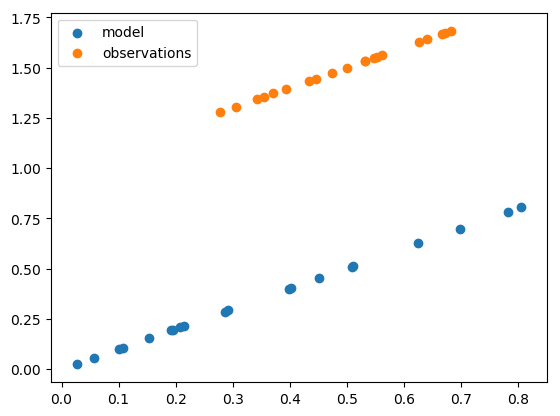

PyObject <matplotlib.legend.Legend object at 0x90389770>

In [106]:
L = 20
t = rand(L)
mod = DataFrame(t = t, x = t)

t = 0.5 .* rand(L) .+ 0.25 
obs = DataFrame(t = t, x = t .+ 1)

scatter(mod.t, mod.x, label = "model")
scatter(obs.t, obs.x, label = "observations")
legend()

In [107]:
sum_residuals_squared(obs,"t", "x", mod, "t", "x")

20.0

# Friction - 1d

In [108]:
tend = 5
dt = 0.0001

μ = 1.5  # = 0.5 * flaeche * ... 

data = DataFrame(t = 0.0, x = 0.0, v = 3.0)

while true
    state = data[nrow(data),:]
    
    f_friction = - μ * state.v^2 
    
    t = state.t + dt
    x = state.x + state.v * dt
    v = state.v + f_friction * dt
    
    
    push!(data, (t, x, v))
    t >= tend && break
end

In [109]:
t_obs = rand(1:nrow(data), 20)
obs = data[t_obs, :];

In [110]:
obs[!, "x_with_noise"] .= obs[!, "x"] .+ 0.05 .* randn(nrow(obs));

In [111]:
obs

,t,x,v,x_with_noise
,Float64,Float64,Float64,Float64
1,3.9237,1.95071,0.160789,1.8764
2,0.2579,0.513602,1.38831,0.485896
3,0.828,1.03537,0.634692,0.979452
4,3.0957,1.80219,0.200913,1.7221
5,1.1798,1.22796,0.475441,1.22743
6,1.2814,1.27459,0.443317,1.25066
7,1.0168,1.14557,0.537984,1.14693
8,4.9078,2.09269,0.129946,2.08268
9,2.1861,1.5886,0.27679,1.61713


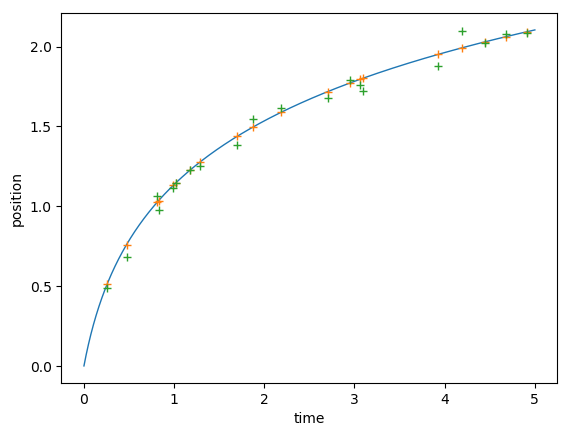

PyObject Text(24.000000000000007, 0.5, 'position')

In [112]:
plot(data.t, data.x ,linewidth = 1)
plot(obs.t,  obs.x  ,linewidth = 0, marker = "+")
plot(obs.t,  obs.x_with_noise  ,linewidth = 0, marker = "+")
xlabel("time")
ylabel("position")

In [113]:
function data_model(x0, v0, μ)
    tend = 6
    dt = 0.0001

    data = DataFrame(t = 0.0, x = float(x0), v = float(v0))

    while true
        state = data[nrow(data),:]

        f_friction = - μ * state.v^2 

        t = state.t + dt
        x = state.x + state.v * dt
        v = state.v + f_friction * dt


        push!(data, (t, x, v))
        t >= tend && break
    end
    
    data
end

data_model (generic function with 1 method)

In [114]:
function likelihood(parameter)
    x0, v0, μ = parameter
    mod = data_model(x0, v0, μ)
    sum_residuals_squared(obs, "t", "x_with_noise", mod, "t", "x")
end

likelihood (generic function with 1 method)

In [115]:
function likelihood_no_friction(parameter)
    x0, v0 = parameter
    mod = data_model(x0, v0, 0)
    sum_residuals_squared(obs, "t", "x_with_noise", mod, "t", "x")
end

likelihood_no_friction (generic function with 1 method)

In [116]:
likelihood([0,3,5])

15.140477814839603

In [117]:
@show res = optimize(likelihood, [0.2, 1, 1])
para = Optim.minimizer(res)

res = optimize(likelihood, [0.2, 1, 1]) =  * Status: success

 * Candidate solution
    Minimizer: [-8.67e-02, 3.38e+00, 1.49e+00]
    Minimum:   3.998345e-02

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [2.00e-01, 1.00e+00, 1.00e+00]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   70  (vs limit Inf)
    Iterations:    103
    f(x) calls:    178



3-element Array{Float64,1}:
 -0.08671428553210819
  3.3774803197251697
  1.491788616310024

In [118]:
@show res = optimize(likelihood_no_friction, [0.2, 1])
para_no_friction = Optim.minimizer(res)

res = optimize(likelihood_no_friction, [0.2, 1]) =  * Status: success

 * Candidate solution
    Minimizer: [7.82e-01, 3.00e-01]
    Minimum:   3.872792e-01

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [2.00e-01, 1.00e+00]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   29  (vs limit Inf)
    Iterations:    34
    f(x) calls:    71



2-element Array{Float64,1}:
 0.7821082017116671
 0.2998196791800604

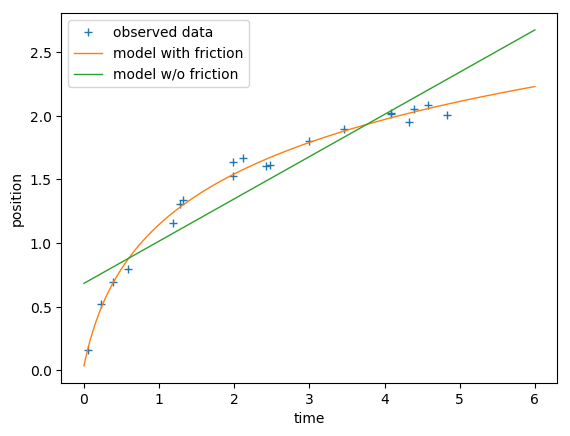

In [56]:
plot(obs.t,  obs.x_with_noise  ,linewidth = 0, marker = "+", label="observed data")

mod = data_model(para ...)
plot(mod.t, mod.x ,linewidth = 1,label="model with friction")


mod = data_model(para_no_friction[1], para_no_friction[2], 0)
plot(mod.t, mod.x ,linewidth = 1,label="model w/o friction")


xlabel("time")
ylabel("position")
legend();

In [57]:
obs[nrow(obs), : ]

,t,x,v,x_with_noise
,Float64,Float64,Float64,Float64
20,4.8262,2.082,0.132046,2.0066
